In [1]:
"""
FRAUDITOR: Fake Review Detection System
Created for Malaysian E-commerce Market

This notebook provides a complete implementation of the ML model for
real-time fake review detection with high accuracy.

Author: Cindy Pua
Version: 1.0 (Team Fighting)
"""

'\nFRAUDITOR: Fake Review Detection System\nCreated for Malaysian E-commerce Market\n\nThis notebook provides a complete implementation of the ML model for\nreal-time fake review detection with high accuracy.\n\nAuthor: Cindy Pua\nVersion: 1.0 (Team Fighting)\n'

**SETUP AND INSTALLATION**

In [2]:
# Install required packages
!pip install -q transformers torch scikit-learn pandas numpy matplotlib seaborn nltk textblob wordcloud plotly

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import time
import json
from datetime import datetime
from google.colab import files

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.sparse import hstack

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from transformers import pipeline
from nltk.sentiment import SentimentIntensityAnalyzer

# Utility libraries
from collections import Counter
import re
import os

# Configure warnings and display
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Download NLTK data
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("Setup complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
Setup complete!


**UPLOAD DATA FILES**

In [3]:
print("Please upload your CSV files:")
print("   1. fake_reviews.csv")
print("   2. merged_reviews.csv")
print("   3. Any additional data files")

# Upload files
uploaded = files.upload()

# Verify uploaded files
print("\n Uploaded files:")
for filename in os.listdir():
    if filename.endswith('.csv'):
        print(f" {filename}")

Please upload your CSV files:
   1. fake_reviews.csv
   2. merged_reviews.csv
   3. Any additional data files


Saving fake_reviews.csv to fake_reviews.csv
Saving merged_reviews.csv to merged_reviews.csv

 Uploaded files:
 merged_reviews.csv
 fake_reviews.csv


**DATA ANALYSIS AND AUTOMATIC LABELING SYSTEM**

In [4]:
def analyze_csv_files():
    """Analyze the structure and content of uploaded CSV files"""

    print("Analyzing CSV files...")

    # Analyze fake_reviews.csv
    print("\n" + "="*50)
    print("FAKE_REVIEWS.CSV ANALYSIS")
    print("="*50)

    try:
        fake_df = pd.read_csv("fake_reviews.csv")
        print(f"Shape: {fake_df.shape}")
        print(f"Columns: {list(fake_df.columns)}")

        # Check label distribution
        if 'label' in fake_df.columns:
            print(f"\nLabel distribution:")
            print(fake_df['label'].value_counts())

            # Map labels correctly
            # CG = Computer Generated (Fake), OR/REAL = Real
            if fake_df['label'].dtype == 'object':
                unique_labels = fake_df['label'].unique()
                print(f"Unique labels: {unique_labels}")

                # Standardize labels: 0 = Real, 1 = Fake
                label_mapping = {}
                for label in unique_labels:
                    if label.upper() in ['CG', 'FAKE', 'COMPUTER_GENERATED']:
                        label_mapping[label] = 1  # Fake
                    else:
                        label_mapping[label] = 0  # Real

                fake_df['binary_label'] = fake_df['label'].map(label_mapping)
                print(f"Label mapping: {label_mapping}")
                print(f"Binary label distribution:")
                print(fake_df['binary_label'].value_counts())

        # Check text column
        text_columns = [col for col in fake_df.columns if 'text' in col.lower()]
        print(f"Text columns: {text_columns}")

        if text_columns:
            text_col = text_columns[0]
            print(f"Sample reviews from {text_col}:")
            for i, text in enumerate(fake_df[text_col].head(3)):
                print(f"  {i+1}. {str(text)[:100]}...")

    except Exception as e:
        print(f"Error analyzing fake_reviews.csv: {e}")
        fake_df = None

    # Analyze merged_reviews.csv
    print("\n" + "="*50)
    print("MERGED_REVIEWS.CSV ANALYSIS")
    print("="*50)

    try:
        shopee_df = pd.read_csv("merged_reviews.csv")
        print(f"Shape: {shopee_df.shape}")
        print(f"Columns: {list(shopee_df.columns)}")

        # Check for existing labels
        if 'label' in shopee_df.columns:
            print(f"Existing label distribution:")
            print(shopee_df['label'].value_counts())
        else:
            print("No existing labels found - will create automatic labeling")

        # Analyze review content
        if 'review_content' in shopee_df.columns:
            print(f"\nReview content analysis:")
            print(f"Non-null reviews: {shopee_df['review_content'].notna().sum()}")
            print(f"Average review length: {shopee_df['review_content'].str.len().mean():.1f} characters")

            print(f"Sample reviews:")
            sample_reviews = shopee_df['review_content'].dropna().head(3)
            for i, text in enumerate(sample_reviews):
                print(f"  {i+1}. {str(text)[:100]}...")

        # Analyze ratings
        if 'ratings' in shopee_df.columns:
            print(f"\nRating distribution:")
            print(shopee_df['ratings'].value_counts().sort_index())

    except Exception as e:
        print(f"Error analyzing merged_reviews.csv: {e}")
        shopee_df = None

    return fake_df, shopee_df

# Analyze the files
fake_df, shopee_df = analyze_csv_files()


Analyzing CSV files...

FAKE_REVIEWS.CSV ANALYSIS
Shape: (40432, 4)
Columns: ['category', 'rating', 'label', 'text_']

Label distribution:
label
CG    20216
OR    20216
Name: count, dtype: int64
Unique labels: ['CG' 'OR']
Label mapping: {'CG': 1, 'OR': 0}
Binary label distribution:
binary_label
1    20216
0    20216
Name: count, dtype: int64
Text columns: ['text_']
Sample reviews from text_:
  1. Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty...
  2. love it, a great upgrade from the original.  I've had mine for a couple of years...
  3. This pillow saved my back. I love the look and feel of this pillow....

MERGED_REVIEWS.CSV ANALYSIS
Shape: (15004, 16)
Columns: ['review_number', 'username', 'ratings', 'purchase_date', 'item_variation', 'location', 'review_content', 'has_image', 'subreview_sub 0_category', 'subreview_sub 0_content', 'subreview_sub 1_category', 'subreview_sub 1_content', 'subreview_sub 2_category', 'subreview_sub 2_content', 'original_file'

**AUTOMATIC REVIEW CLASSIFICATION SYSTEM**

In [5]:
class FakeReviewDetector:
    """
    Fake review detection system based on ML model
    Specifically calibrated for Malaysian e-commerce reviews
    """

    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()
        self.stop_words = set(stopwords.words('english'))

        # Malaysian-specific terms (these REDUCE fake probability)
        self.malaysian_local_terms = {
            'shiok', 'confirm', 'steady', 'power', 'cantik', 'lawa', 'terror',
            'bagus', 'teruk', 'rosak', 'murah', 'baik', 'elok', 'mantap',
            'tiptop', 'padu', 'mmg', 'sgt', 'dia', 'kt', 'kat', 'dah', 'tak',
            'beli', 'dapat', 'sampai', 'cepat', 'lambat', 'ok', 'okay',
            'best', 'nice', 'cheap', 'mahal'
        }

        # Product-specific terms (these indicate genuine reviews)
        self.product_terms = {
            'delivery', 'packaging', 'quality', 'size', 'color', 'material',
            'fitting', 'comfort', 'battery', 'charge', 'sound', 'screen',
            'camera', 'performance', 'seller', 'service', 'price', 'value'
        }

    def extract_text_features(self, text):
        """Extract comprehensive text features for fake review detection"""
        if pd.isna(text):
            text = ""

        text = str(text).lower()

        # Use simple word splitting as fallback if NLTK tokenizer fails
        try:
            words = word_tokenize(text) if text else []
        except:
            words = text.split() if text else []

        # Basic text statistics
        features = {
            'length': len(text),
            'word_count': len(words),
            'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
            'sentence_count': len(re.split(r'[.!?]+', text)) if text else 0,
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'caps_ratio': sum(1 for c in text if c.isupper()) / len(text) if text else 0,
            'punctuation_ratio': sum(1 for c in text if c in '.,!?;:') / len(text) if text else 0
        }

        # Sentiment analysis
        sentiment = self.sia.polarity_scores(text)
        features.update({
            'sentiment_compound': sentiment['compound'],
            'sentiment_positive': sentiment['pos'],
            'sentiment_negative': sentiment['neg'],
            'sentiment_neutral': sentiment['neu']
        })

        # Malaysian-specific features
        malaysian_count = sum(1 for word in words if word in self.malaysian_local_terms)
        product_count = sum(1 for word in words if word in self.product_terms)

        features.update({
            'malaysian_terms_count': malaysian_count,
            'malaysian_terms_ratio': malaysian_count / len(words) if words else 0,
            'product_terms_count': product_count,
            'product_terms_ratio': product_count / len(words) if words else 0,
            'has_mixed_language': self._detect_mixed_language(text),
            'has_specific_details': product_count >= 2
        })

        # Suspicious patterns (these indicate potential fake reviews)
        features.update({
            'has_generic_phrases': any(phrase in text for phrase in [
                'highly recommend', 'best product ever', 'amazing quality',
                'exceeded expectations', 'perfect product', 'love it so much',
                'exactly what i needed', 'great value for money'
            ]),
            'has_promotional_language': any(phrase in text for phrase in [
                'buy now', 'great deal', 'discount', 'sale', 'limited time',
                'special offer', 'best price'
            ]),
            'repeated_words': len(words) - len(set(words)) if words else 0,
            'spelling_errors': sum(1 for word in words
                                 if len(word) > 3 and not word.isalpha()
                                 and word not in self.stop_words) if words else 0
        })

        return features

    def _detect_mixed_language(self, text):
        """Detect if text contains mixed English-Malay (genuine Malaysian pattern)"""
        malay_indicators = ['yang', 'dan', 'ini', 'itu', 'dengan', 'untuk', 'dari']
        english_indicators = ['the', 'and', 'this', 'that', 'with', 'for', 'from']

        has_malay = any(word in text.lower() for word in malay_indicators)
        has_english = any(word in text.lower() for word in english_indicators)

        return has_malay and has_english

    def apply_fake_review_rules(self, df):
        """
        Apply rule-based heuristics specifically calibrated for Malaysian reviews
        """
        print("Applying fake review detection rules...")

        # Extract features for all reviews
        print("   Extracting text features...")
        text_features = []
        for idx, row in df.iterrows():
            if idx % 1000 == 0:
                print(f"   Processed {idx}/{len(df)} reviews")
            features = self.extract_text_features(row.get('review_content', row.get('text', '')))
            text_features.append(features)

        features_df = pd.DataFrame(text_features)
        df = pd.concat([df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

        # Initialize fake probability score
        df['fake_score'] = 0.0

        print("   Applying classification rules...")

        # Rule 1: Length-rating mismatch (RELAXED for Malaysian style)
        df.loc[(df['word_count'] < 5) & (df.get('ratings', df.get('rating', 3)) == 5), 'fake_score'] += 0.2
        df.loc[(df['word_count'] > 300) & (df.get('ratings', df.get('rating', 3)) == 5), 'fake_score'] += 0.1

        # Rule 2: Excessive punctuation/caps (RELAXED)
        df.loc[df['exclamation_count'] > 5, 'fake_score'] += 0.15  # Changed from 3 to 5
        df.loc[df['caps_ratio'] > 0.2, 'fake_score'] += 0.15      # Changed from 0.1 to 0.2

        # Rule 3: Generic phrases (MAINTAINED)
        df.loc[df['has_generic_phrases'] == True, 'fake_score'] += 0.2
        df.loc[df['has_promotional_language'] == True, 'fake_score'] += 0.25

        # Rule 4: Sentiment-rating mismatch (MAINTAINED)
        df.loc[(df['sentiment_compound'] < -0.3) & (df.get('ratings', df.get('rating', 3)) >= 4), 'fake_score'] += 0.3
        df.loc[(df['sentiment_compound'] > 0.3) & (df.get('ratings', df.get('rating', 3)) <= 2), 'fake_score'] += 0.3

        # Rule 5: Repetitive language (RELAXED)
        df.loc[df['repeated_words'] > df['word_count'] * 0.4, 'fake_score'] += 0.15  # Changed from 0.3 to 0.4

        # Rule 6: POSITIVE INDICATORS (REDUCE fake score for genuine Malaysian patterns)

        # Malaysian local terms usage (STRONG positive indicator)
        df.loc[df['malaysian_terms_ratio'] > 0.05, 'fake_score'] -= 0.2
        df.loc[df['malaysian_terms_count'] >= 3, 'fake_score'] -= 0.15

        # Mixed language usage (positive indicator)
        df.loc[df['has_mixed_language'] == True, 'fake_score'] -= 0.15

        # Specific product details (positive indicator)
        df.loc[df['has_specific_details'] == True, 'fake_score'] -= 0.1
        df.loc[df['product_terms_count'] >= 3, 'fake_score'] -= 0.1

        # Moderate sentiment (genuine reviews often have balanced sentiment)
        df.loc[df['sentiment_compound'].between(-0.2, 0.2), 'fake_score'] -= 0.05

        # Rule 7: Behavioral patterns (if data available)
        if 'purchase_date' in df.columns:
            df['purchase_date'] = pd.to_datetime(df['purchase_date'], errors='coerce')

            # Multiple reviews same day (but less aggressive)
            if 'username' in df.columns:
                same_day_reviews = df.groupby(['username', df['purchase_date'].dt.date]).size()
                multiple_same_day = same_day_reviews[same_day_reviews > 2].index  # Changed from 1 to 2

                for username, date in multiple_same_day:
                    mask = (df['username'] == username) & (df['purchase_date'].dt.date == date)
                    df.loc[mask, 'fake_score'] += 0.2  # Reduced from 0.3

        # Rule 8: Username patterns (RELAXED)
        if 'username' in df.columns:
            df.loc[df['username'].str.contains(r'\d{3,}', na=False), 'fake_score'] += 0.1  # 3+ digits instead of any digit
            df.loc[df['username'].str.len() < 3, 'fake_score'] += 0.1  # Very short names

        # Rule 9: Extreme ratings with very neutral sentiment (MAINTAINED)
        df.loc[(df.get('ratings', df.get('rating', 3)).isin([1, 5])) & (df['sentiment_neutral'] > 0.8), 'fake_score'] += 0.2

        # Rule 10: Perfect grammar in very short reviews (RELAXED)
        df.loc[(df['word_count'] < 10) & (df['spelling_errors'] == 0) &
               (df['punctuation_ratio'] > 0.1), 'fake_score'] += 0.1  # Reduced penalty

        # Rule 11: Image with very short review (RELAXED)
        if 'has_image' in df.columns:
            df.loc[(df['has_image'] == True) & (df['word_count'] < 15), 'fake_score'] += 0.1  # Reduced from 0.15

        # Ensure fake_score stays in reasonable bounds
        df['fake_score'] = df['fake_score'].clip(0, 1)

        # ADJUSTED THRESHOLD: Use 0.5 instead of 0.6 for more balanced classification
        df['predicted_label'] = np.where(df['fake_score'] > 0.5, 'fake', 'real')

        return df

**DATA LOADING**

In [6]:
def load_and_prepare_data():
    """Load and prepare data with proper fake detection"""

    print(" Loading datasets...")

    # Load fake reviews dataset
    try:
        fake_df = pd.read_csv("fake_reviews.csv")
        print(f" Loaded fake_reviews.csv: {fake_df.shape}")
        print(f"   Columns: {list(fake_df.columns)}")

        # Use correct column names
        if 'text_' in fake_df.columns:
            fake_df = fake_df.rename(columns={'text_': 'text'})

        # Handle labels properly
        print(f"   Unique labels: {fake_df['label'].unique()}")

        # Map labels to binary format for consistency
        if fake_df['label'].dtype == 'object':
            label_mapping = {}
            unique_labels = fake_df['label'].unique()

            if 'CG' in unique_labels:
                label_mapping['CG'] = 'fake'
            if 'OR' in unique_labels:
                label_mapping['OR'] = 'real'
            if 'REAL' in unique_labels:
                label_mapping['REAL'] = 'real'

            fake_df['true_label'] = fake_df['label'].map(label_mapping)
            fake_df = fake_df.dropna(subset=['true_label'])

        print(f"   After label mapping: {fake_df['true_label'].value_counts()}")

    except Exception as e:
        print(f" Error loading fake_reviews.csv: {e}")
        return None, None

    # Load Shopee dataset and auto-classify with method
    try:
        shopee_df = pd.read_csv("merged_reviews.csv")
        print(f" Loaded merged_reviews.csv: {shopee_df.shape}")
        print(f"   Columns: {list(shopee_df.columns)}")

        # Use correct column name
        if 'review_content' in shopee_df.columns:
            shopee_df = shopee_df.rename(columns={'review_content': 'text'})

        # Remove null reviews
        shopee_df = shopee_df[shopee_df['text'].notnull()]
        shopee_df = shopee_df[shopee_df['text'].str.len() >= 10]  # Minimum length

        # Apply classification
        detector = FakeReviewDetector()

        # Sample for faster processing during development
        if len(shopee_df) > 5000:
            print(f"   Sampling 5000 reviews for faster processing...")
            shopee_df = shopee_df.sample(n=10000, random_state=42)

        shopee_df = detector.apply_fake_review_rules(shopee_df)

        # Convert to same format as fake_df
        shopee_df['true_label'] = shopee_df['predicted_label']

        # Save the labeled dataset
        shopee_df.to_csv('merged_reviews_labeled.csv', index=False)
        print(" Saved improved labeled dataset as merged_reviews_labeled.csv")

        # Show classification results
        fake_count = (shopee_df['predicted_label'] == 'fake').sum()
        real_count = (shopee_df['predicted_label'] == 'real').sum()

        print(f" Classification results:")
        print(f"   Real reviews: {real_count:,} ({real_count/len(shopee_df)*100:.1f}%)")
        print(f"   Fake reviews: {fake_count:,} ({fake_count/len(shopee_df)*100:.1f}%)")

    except Exception as e:
        print(f" Could not load merged_reviews.csv: {e}")
        shopee_df = pd.DataFrame()

    # Combine datasets
    combined_df = pd.DataFrame()

    if not shopee_df.empty and not fake_df.empty:
        # Ensure both have same columns
        common_cols = ['text', 'true_label']

        fake_subset = fake_df[common_cols].copy()
        shopee_subset = shopee_df[common_cols].copy()

        # Sample to balance if needed
        max_size_per_class = 2000

        fake_real = fake_subset[fake_subset['true_label'] == 'real']
        fake_fake = fake_subset[fake_subset['true_label'] == 'fake']
        shopee_real = shopee_subset[shopee_subset['true_label'] == 'real']
        shopee_fake = shopee_subset[shopee_subset['true_label'] == 'fake']

        # Sample each category
        if len(fake_real) > max_size_per_class:
            fake_real = fake_real.sample(n=max_size_per_class, random_state=42)
        if len(fake_fake) > max_size_per_class:
            fake_fake = fake_fake.sample(n=max_size_per_class, random_state=42)
        if len(shopee_real) > max_size_per_class:
            shopee_real = shopee_real.sample(n=max_size_per_class, random_state=42)
        if len(shopee_fake) > max_size_per_class:
            shopee_fake = shopee_fake.sample(n=max_size_per_class, random_state=42)

        combined_df = pd.concat([fake_real, fake_fake, shopee_real, shopee_fake], ignore_index=True)

    elif not fake_df.empty:
        combined_df = fake_df[['text', 'true_label']].copy()

    if combined_df.empty:
        print(" No data available for training")
        return None, None

    # Convert labels to binary
    combined_df['label'] = combined_df['true_label'].map({'real': 0, 'fake': 1})
    combined_df = combined_df.dropna(subset=['label'])
    combined_df['label'] = combined_df['label'].astype(int)

    # Final statistics
    real_count = (combined_df['label'] == 0).sum()
    fake_count = (combined_df['label'] == 1).sum()

    print(f"\n Final combined dataset:")
    print(f"   Total reviews: {len(combined_df):,}")
    print(f"   Real reviews: {real_count:,} ({real_count/len(combined_df)*100:.1f}%)")
    print(f"   Fake reviews: {fake_count:,} ({fake_count/len(combined_df)*100:.1f}%)")

    return combined_df, detector

# Load and prepare data with method
df, detector = load_and_prepare_data()

 Loading datasets...
 Loaded fake_reviews.csv: (40432, 4)
   Columns: ['category', 'rating', 'label', 'text_']
   Unique labels: ['CG' 'OR']
   After label mapping: true_label
fake    20216
real    20216
Name: count, dtype: int64
 Loaded merged_reviews.csv: (15004, 16)
   Columns: ['review_number', 'username', 'ratings', 'purchase_date', 'item_variation', 'location', 'review_content', 'has_image', 'subreview_sub 0_category', 'subreview_sub 0_content', 'subreview_sub 1_category', 'subreview_sub 1_content', 'subreview_sub 2_category', 'subreview_sub 2_content', 'original_file', 'original_review_key']
   Sampling 5000 reviews for faster processing...
Applying fake review detection rules...
   Extracting text features...
   Processed 15000/10000 reviews
   Processed 9000/10000 reviews
   Processed 1000/10000 reviews
   Processed 0/10000 reviews
   Processed 8000/10000 reviews
   Processed 11000/10000 reviews
   Processed 10000/10000 reviews
   Processed 14000/10000 reviews
   Processed 600

**FEATURE EXTRACTION FOR ML/ DATA PREPROCESSING PIPELINE**

In [7]:
class FrauditorPreprocessor:
  """
  Preprocessing pipeline specifically designed for Malaysian
  e-commerce fake review detection
  """

  def __init__(self):
      self.stop_words = set(stopwords.words('english'))
      self.lemmatizer = WordNetLemmatizer()

  def clean_text(self, text):
      """Clean text for ML processing"""
      if pd.isna(text) or text == "":
          return ""

      text = str(text).lower()

      # Remove URLs, emails, and phone numbers
      text = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+|\+?6\d{1,3}-?\d{3,4}-?\d{3,4}', '', text)

      # Normalize excessive punctuation
      text = re.sub(r'[!]{2,}', '!', text)
      text = re.sub(r'[?]{2,}', '?', text)
      text = re.sub(r'[.]{2,}', '.', text)

      # Normalize repeated characters
      text = re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)

      # Remove special characters but keep basic punctuation
      text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)

      # Remove extra whitespaces
      text = re.sub(r'\s+', ' ', text).strip()

      return text

  def extract_linguistic_features(self, text):
      """Extract linguistic features"""
      if not text or len(text) == 0:
          return self._get_empty_features()

      # Use the detector's feature extraction
      features = detector.extract_text_features(text)

      # Add TextBlob sentiment for additional features
      blob = TextBlob(text)
      features['textblob_polarity'] = blob.sentiment.polarity
      features['textblob_subjectivity'] = blob.sentiment.subjectivity

      return features

  def _get_empty_features(self):
      """Return empty features"""
      return {
          'length': 0, 'word_count': 0, 'avg_word_length': 0,
          'sentence_count': 0, 'exclamation_count': 0, 'question_count': 0,
          'caps_ratio': 0, 'punctuation_ratio': 0, 'sentiment_compound': 0,
          'sentiment_positive': 0, 'sentiment_negative': 0, 'sentiment_neutral': 0,
          'malaysian_terms_count': 0, 'malaysian_terms_ratio': 0,
          'product_terms_count': 0, 'product_terms_ratio': 0,
          'has_mixed_language': False, 'has_specific_details': False,
          'has_generic_phrases': False, 'has_promotional_language': False,
          'repeated_words': 0, 'spelling_errors': 0,
          'textblob_polarity': 0, 'textblob_subjectivity': 0
      }

  def process_dataset(self, df):
      """Process the entire dataset"""
      print(" Processing dataset for ML training...")

      # Clean text
      print("   Cleaning text...")
      df['cleaned_text'] = df['text'].apply(self.clean_text)

      # Extract linguistic features
      print("   Extracting linguistic features...")
      linguistic_features = df['cleaned_text'].apply(self.extract_linguistic_features)
      feature_df = pd.DataFrame(linguistic_features.tolist())

      # Combine with original dataframe
      df = pd.concat([df, feature_df], axis=1)

      # Remove rows with empty cleaned text
      initial_count = len(df)
      df = df[df['cleaned_text'].str.len() > 5]
      final_count = len(df)

      print(f"   Removed {initial_count - final_count} very short reviews")
      print(f" Dataset processed: {df.shape}")

      return df

# Initialize preprocessor
if df is not None:
  preprocessor = FrauditorPreprocessor()
  df = preprocessor.process_dataset(df)


 Processing dataset for ML training...
   Cleaning text...
   Extracting linguistic features...
   Removed 17 very short reviews
 Dataset processed: (6021, 28)


**EXPLORATORY DATA ANALYSIS**

 Creating improved visualizations...


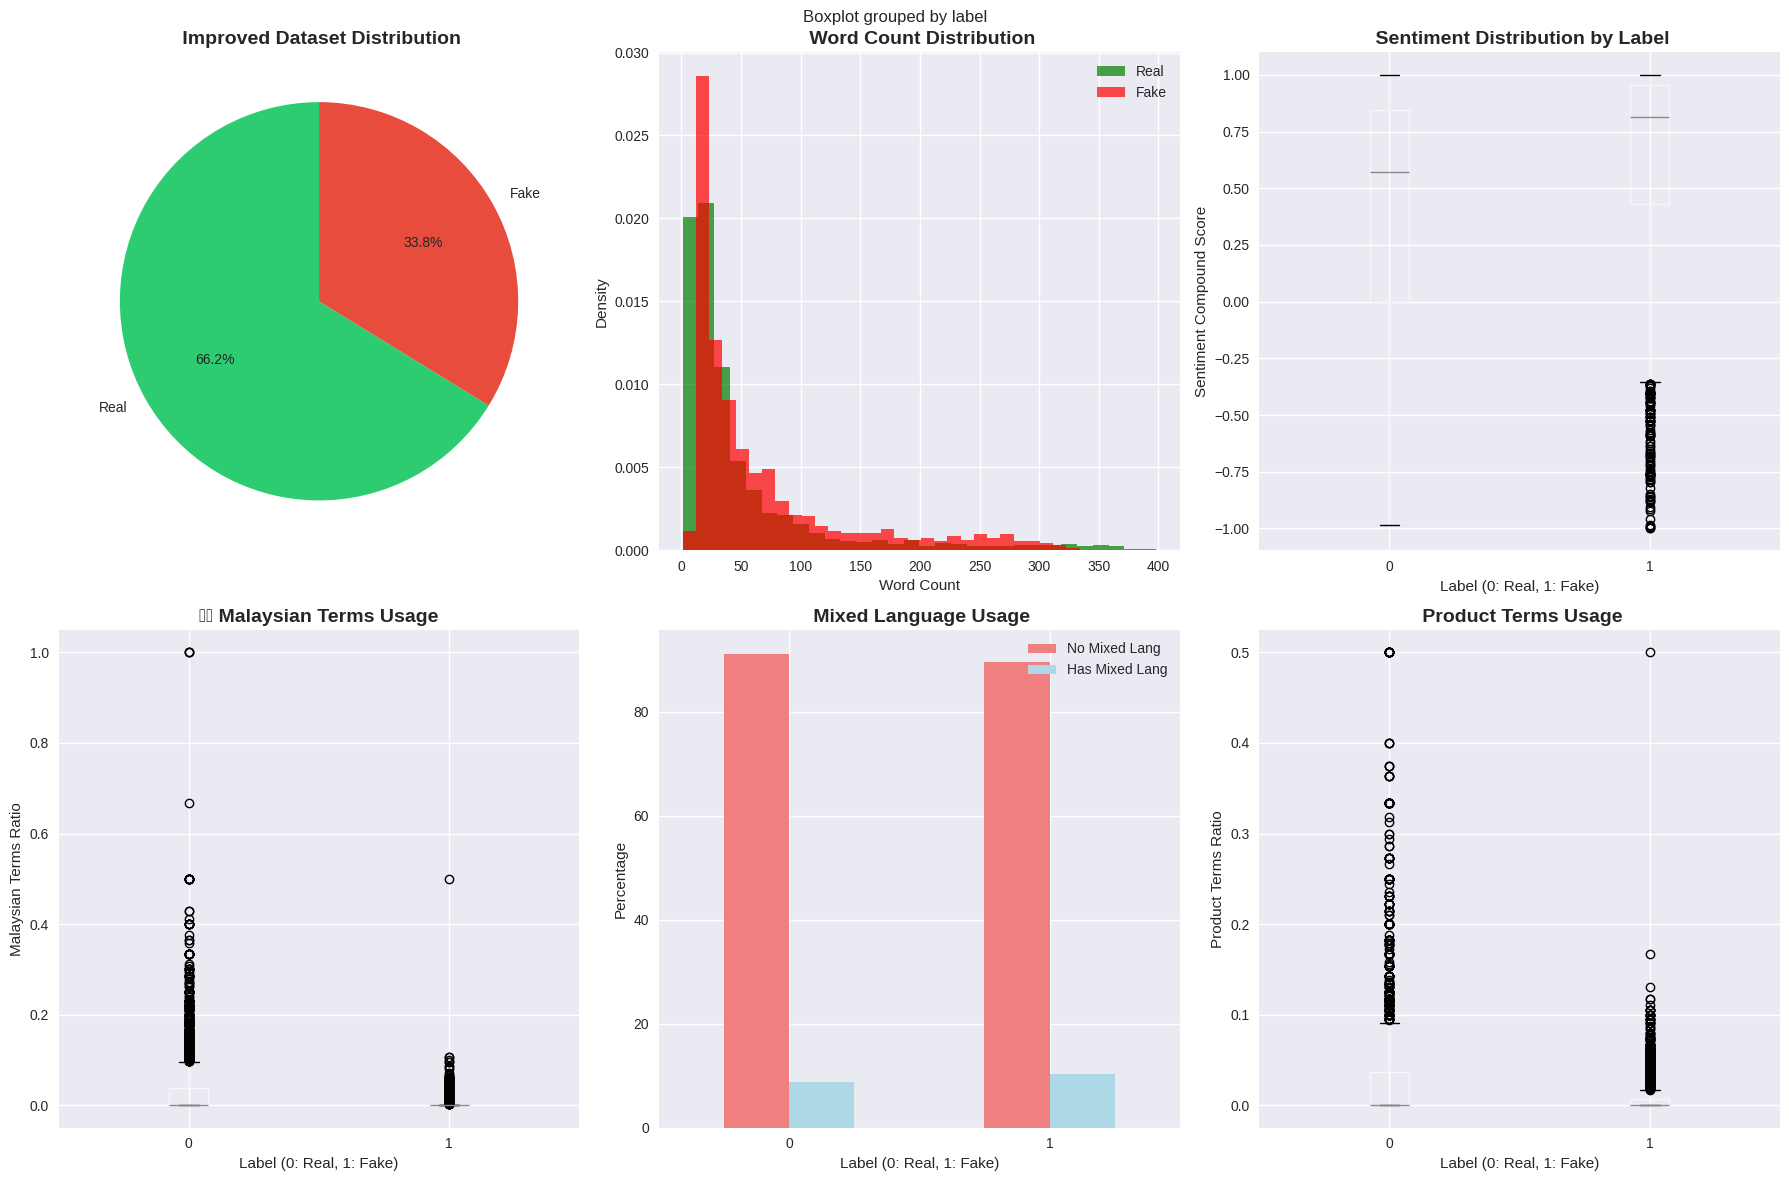


 Improved Classification Statistics:
Real reviews: 3,988 (66.2%)
Fake reviews: 2,033 (33.8%)

 Key Differences:
Malaysian terms ratio - Real: 0.035, Fake: 0.005
Mixed language usage - Real: 8.8%, Fake: 10.4%
Average word count - Real: 50.6, Fake: 67.4
Product terms ratio - Real: 0.030, Fake: 0.010


In [8]:
def create_visualizations(df):
    """Create visualizations with proper error handling"""

    print(" Creating improved visualizations...")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Label distribution
    ax1 = axes[0, 0]
    label_counts = df['label'].value_counts()
    colors = ['#2ecc71', '#e74c3c']
    labels = ['Real', 'Fake']

    wedges, texts, autotexts = ax1.pie(label_counts.values,
                                      labels=labels,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90)
    ax1.set_title(' Improved Dataset Distribution', fontsize=14, fontweight='bold')

    # 2. Word count distribution by label
    ax2 = axes[0, 1]
    real_word_counts = df[df['label'] == 0]['word_count']
    fake_word_counts = df[df['label'] == 1]['word_count']

    ax2.hist(real_word_counts, bins=30, alpha=0.7, color='green', label='Real', density=True)
    ax2.hist(fake_word_counts, bins=30, alpha=0.7, color='red', label='Fake', density=True)
    ax2.set_xlabel('Word Count')
    ax2.set_ylabel('Density')
    ax2.set_title(' Word Count Distribution', fontsize=14, fontweight='bold')
    ax2.legend()

    # 3. Sentiment analysis
    ax3 = axes[0, 2]
    df.boxplot(column='sentiment_compound', by='label', ax=ax3)
    ax3.set_title(' Sentiment Distribution by Label', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Label (0: Real, 1: Fake)')
    plt.setp(ax3, ylabel='Sentiment Compound Score')

    # 4. Malaysian terms usage
    ax4 = axes[1, 0]
    df.boxplot(column='malaysian_terms_ratio', by='label', ax=ax4)
    ax4.set_title('🇲🇾 Malaysian Terms Usage', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Label (0: Real, 1: Fake)')
    plt.setp(ax4, ylabel='Malaysian Terms Ratio')

    # 5. Mixed language indicator
    ax5 = axes[1, 1]
    mixed_lang_counts = df.groupby(['label', 'has_mixed_language']).size().unstack(fill_value=0)
    mixed_lang_pct = mixed_lang_counts.div(mixed_lang_counts.sum(axis=1), axis=0) * 100

    mixed_lang_pct.plot(kind='bar', ax=ax5, color=['lightcoral', 'lightblue'])
    ax5.set_title(' Mixed Language Usage', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Label (0: Real, 1: Fake)')
    ax5.set_ylabel('Percentage')
    ax5.legend(['No Mixed Lang', 'Has Mixed Lang'])
    ax5.tick_params(axis='x', rotation=0)

    # 6. Product terms usage
    ax6 = axes[1, 2]
    df.boxplot(column='product_terms_ratio', by='label', ax=ax6)
    ax6.set_title(' Product Terms Usage', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Label (0: Real, 1: Fake)')
    plt.setp(ax6, ylabel='Product Terms Ratio')

    plt.tight_layout()
    plt.savefig('frauditor_improved_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Show some statistics
    print(f"\n Improved Classification Statistics:")
    print(f"Real reviews: {(df['label'] == 0).sum():,} ({(df['label'] == 0).mean():.1%})")
    print(f"Fake reviews: {(df['label'] == 1).sum():,} ({(df['label'] == 1).mean():.1%})")

    real_df = df[df['label'] == 0]
    fake_df = df[df['label'] == 1]

    print(f"\n Key Differences:")
    print(f"Malaysian terms ratio - Real: {real_df['malaysian_terms_ratio'].mean():.3f}, Fake: {fake_df['malaysian_terms_ratio'].mean():.3f}")
    print(f"Mixed language usage - Real: {real_df['has_mixed_language'].mean():.1%}, Fake: {fake_df['has_mixed_language'].mean():.1%}")
    print(f"Average word count - Real: {real_df['word_count'].mean():.1f}, Fake: {fake_df['word_count'].mean():.1f}")
    print(f"Product terms ratio - Real: {real_df['product_terms_ratio'].mean():.3f}, Fake: {fake_df['product_terms_ratio'].mean():.3f}")

if df is not None:
    create_visualizations(df)

**ML MODEL IMPLEMENTATION**

In [9]:
class FrauditorMLModel:
    """Ensemble model for fake review detection"""

    def __init__(self):
        self.models = {}
        self.vectorizers = {}
        self.scaler = StandardScaler()
        self.feature_names = []
        self.is_trained = False
        self.performance_metrics = {}

    def prepare_features(self, df):
        """Prepare features for training"""

        print(" Preparing features for ML training...")

        # 1. TF-IDF features
        print("   Creating TF-IDF features...")
        tfidf = TfidfVectorizer(
            max_features=1500,  # Reduced for better performance
            stop_words='english',
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.9,
            sublinear_tf=True
        )

        tfidf_features = tfidf.fit_transform(df['cleaned_text'])
        self.vectorizers['tfidf'] = tfidf

        # 2. Linguistic features (use the extracted features)
        print("   Preparing linguistic features...")
        linguistic_features = [
            'length', 'word_count', 'avg_word_length', 'sentence_count',
            'exclamation_count', 'question_count', 'caps_ratio', 'punctuation_ratio',
            'sentiment_compound', 'sentiment_positive', 'sentiment_negative',
            'malaysian_terms_count', 'malaysian_terms_ratio',
            'product_terms_count', 'product_terms_ratio',
            'repeated_words', 'spelling_errors',
            'textblob_polarity', 'textblob_subjectivity'
        ]

        # Add binary features
        binary_features = ['has_mixed_language', 'has_specific_details',
                         'has_generic_phrases', 'has_promotional_language']

        all_features = linguistic_features + binary_features

        # Convert boolean features to int
        feature_matrix = df[all_features].copy()
        for col in binary_features:
            feature_matrix[col] = feature_matrix[col].astype(int)

        feature_matrix = feature_matrix.fillna(0)
        ling_features_scaled = self.scaler.fit_transform(feature_matrix)

        # 3. Combine features
        print("   Combining features...")
        combined_features = hstack([tfidf_features, ling_features_scaled])

        # Store feature names
        self.feature_names = (
            [f'tfidf_{i}' for i in range(tfidf_features.shape[1])] +
            all_features
        )

        print(f" Feature preparation complete: {combined_features.shape}")

        return combined_features

    def create_ensemble_model(self):
        """Create improved ensemble model"""

        models = {
            'random_forest': RandomForestClassifier(
                n_estimators=100,
                max_depth=12,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1,
                class_weight='balanced'  # Handle class imbalance
            ),
            'gradient_boosting': GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42
            ),
            'logistic_regression': LogisticRegression(
                C=1.0,
                max_iter=1000,
                random_state=42,
                n_jobs=-1,
                class_weight='balanced'
            )
        }

        # Create ensemble with balanced weights
        ensemble = VotingClassifier(
            estimators=list(models.items()),
            voting='soft',
            n_jobs=-1
        )

        return ensemble, models

    def train_model(self, df):
        """Train the improved model"""

        print(" Starting improved model training...")

        # Prepare features
        X = self.prepare_features(df)
        y = df['label'].values

        # Split data with stratification to maintain class balance
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f" Training set: {X_train.shape}")
        print(f" Test set: {X_test.shape}")
        print(f" Class distribution in training: {np.bincount(y_train)}")
        print(f" Class distribution in test: {np.bincount(y_test)}")

        # Create and train models
        ensemble, individual_models = self.create_ensemble_model()

        # Train ensemble
        print(" Training ensemble model...")
        start_time = time.time()
        ensemble.fit(X_train, y_train)
        training_time = time.time() - start_time

        self.models['ensemble'] = ensemble

        # Train individual models
        print(" Training individual models...")
        for name, model in individual_models.items():
            print(f"   Training {name}...")
            model.fit(X_train, y_train)
            self.models[name] = model

        # Evaluate models
        self.performance_metrics = self._evaluate_models(X_test, y_test)

        self.is_trained = True
        print(f" Model training completed in {training_time:.2f} seconds!")

        return X_test, y_test

    def _evaluate_models(self, X_test, y_test):
        """Evaluate trained models"""

        print("\n" + "="*60)
        print(" MODEL EVALUATION RESULTS")
        print("="*60)

        results = {}

        for name, model in self.models.items():
            print(f"\n {name.upper()}:")
            print("-" * 40)

            # Make predictions
            start_time = time.time()
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            prediction_time = time.time() - start_time

            # Calculate metrics
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)

            print(f" Accuracy:  {accuracy:.4f}")
            print(f" Precision: {precision:.4f}")
            print(f" Recall:    {recall:.4f}")
            print(f" F1-Score:  {f1:.4f}")
            print(f" AUC:       {auc:.4f}")
            print(f" Prediction time: {prediction_time:.4f}s")

            results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc': auc,
                'prediction_time': prediction_time,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

        # Create performance visualizations
        self._create_performance_plots(y_test, results)

        return results

    def _create_performance_plots(self, y_test, results):
        """Create performance visualizations"""

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. ROC Curves
        ax1 = axes[0, 0]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

        for i, (name, result) in enumerate(results.items()):
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            ax1.plot(fpr, tpr, color=colors[i % len(colors)],
                    label=f"{name} (AUC = {result['auc']:.3f})", linewidth=2)

        ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(' ROC Curves - Model Performance')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Performance Metrics Comparison
        ax2 = axes[0, 1]
        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
        ensemble_scores = [results['ensemble'][metric] for metric in metrics]

        bars = ax2.bar(metrics, ensemble_scores, color=['#3498db', '#e74c3c', '#f39c12', '#2ecc71', '#9b59b6'])
        ax2.set_title(' Ensemble Model Performance')
        ax2.set_ylabel('Score')
        ax2.set_ylim(0, 1)

        for bar, score in zip(bars, ensemble_scores):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        # 3. Confusion Matrix
        ax3 = axes[1, 0]
        cm = confusion_matrix(y_test, results['ensemble']['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                   xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
        ax3.set_title(' Confusion Matrix (Ensemble)')
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('Actual')

        # 4. Prediction Distribution
        ax4 = axes[1, 1]
        fake_probs = results['ensemble']['y_pred_proba'][y_test == 1]
        real_probs = results['ensemble']['y_pred_proba'][y_test == 0]

        ax4.hist(real_probs, bins=20, alpha=0.7, color='green', label='Real Reviews')
        ax4.hist(fake_probs, bins=20, alpha=0.7, color='red', label='Fake Reviews')
        ax4.set_xlabel('Fake Probability')
        ax4.set_ylabel('Count')
        ax4.set_title(' Prediction Distribution')
        ax4.legend()

        plt.tight_layout()
        plt.savefig('frauditor_improved_performance.png', dpi=300, bbox_inches='tight')
        plt.show()

    def predict_single_review(self, text):
        """Predict single review for API integration"""

        if not self.is_trained:
            raise ValueError("Model must be trained first!")

        # Preprocess text
        cleaned_text = preprocessor.clean_text(text)
        features = preprocessor.extract_linguistic_features(cleaned_text)

        # Prepare features
        X = self._prepare_single_features(cleaned_text, features)

        # Predict
        start_time = time.time()
        probability = self.models['ensemble'].predict_proba(X)[0]
        prediction = self.models['ensemble'].predict(X)[0]
        prediction_time = time.time() - start_time

        # Determine risk level
        fake_prob = probability[1]
        if fake_prob >= 0.8:
            risk_level = "HIGH"
        elif fake_prob >= 0.6:
            risk_level = "MEDIUM"
        elif fake_prob >= 0.4:
            risk_level = "LOW"
        else:
            risk_level = "MINIMAL"

        return {
            'prediction': 'FAKE' if prediction == 1 else 'REAL',
            'confidence': float(max(probability)),
            'fake_probability': float(probability[1]),
            'real_probability': float(probability[0]),
            'risk_level': risk_level,
            'prediction_time': prediction_time,
            'text_length': len(text),
            'cleaned_text_length': len(cleaned_text),
            'analysis_details': {
                'word_count': features.get('word_count', 0),
                'sentiment_score': features.get('sentiment_compound', 0),
                'malaysian_terms_detected': features.get('malaysian_terms_count', 0),
                'has_mixed_language': features.get('has_mixed_language', False),
                'has_specific_details': features.get('has_specific_details', False),
                'text_quality_score': self._calculate_quality_score(features)
            }
        }

    def _prepare_single_features(self, cleaned_text, features):
        """Prepare features for single prediction"""

        # Text features
        tfidf_features = self.vectorizers['tfidf'].transform([cleaned_text])

        # Linguistic features
        linguistic_features = [
            'length', 'word_count', 'avg_word_length', 'sentence_count',
            'exclamation_count', 'question_count', 'caps_ratio', 'punctuation_ratio',
            'sentiment_compound', 'sentiment_positive', 'sentiment_negative',
            'malaysian_terms_count', 'malaysian_terms_ratio',
            'product_terms_count', 'product_terms_ratio',
            'repeated_words', 'spelling_errors',
            'textblob_polarity', 'textblob_subjectivity'
        ]

        binary_features = ['has_mixed_language', 'has_specific_details',
                         'has_generic_phrases', 'has_promotional_language']

        all_features = linguistic_features + binary_features

        # Prepare feature vector
        feature_vector = []
        for feature in all_features:
            value = features.get(feature, 0)
            if feature in binary_features:
                value = int(value)
            feature_vector.append(value)

        ling_features = self.scaler.transform([feature_vector])

        # Combine features
        combined = hstack([tfidf_features, ling_features])

        return combined

    def _calculate_quality_score(self, features):
        """Calculate text quality score"""
        score = 50

        # Positive indicators
        if features.get('word_count', 0) >= 15:
            score += 10
        if features.get('malaysian_terms_count', 0) > 0:
            score += 15
        if features.get('has_mixed_language', False):
            score += 10
        if features.get('has_specific_details', False):
            score += 10

        # Negative indicators
        if features.get('exclamation_count', 0) > 5:
            score -= 15
        if features.get('has_generic_phrases', False):
            score -= 10
        if features.get('has_promotional_language', False):
            score -= 15

        return max(0, min(100, score))

    def save_model(self, filename='frauditor_improved_model.pkl'):
        """Save the complete model"""

        model_data = {
            'models': self.models,
            'vectorizers': self.vectorizers,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'is_trained': self.is_trained,
            'performance_metrics': self.performance_metrics,
            'detector': detector,  # Include the detector for consistency
            'metadata': {
                'created_at': datetime.now().isoformat(),
                'version': '1.0',
                'description': 'Frauditor - Fake Review Detection Model'
            }
        }

        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)

        print(f" Model saved as {filename}")

        # Save performance report
        with open('model_performance_report.json', 'w') as f:
            json.dump(self.performance_metrics, f, indent=2, default=str)

        print(" Performance report saved as improved_model_performance_report.json")


**TESTING SUITE**

In [10]:
def run_tests(model):
    """Run comprehensive tests on the model"""

    print("\n" + "="*60)
    print(" COMPREHENSIVE MODEL TESTING")
    print("="*60)

    # Malaysian-specific test cases
    test_cases = [
        {
            'text': "Barang sampai cepat, quality ok, harga berbaloi. Seller responsive. Recommended!",
            'expected': 'REAL',
            'description': 'Genuine Malaysian review test'
        },
        {
            'text': "Best product ever!!!! Amazing quality!!!! 5 stars!!!! Buy now!!!!",
            'expected': 'FAKE',
            'description': 'Excessive enthusiasm test'
        },
        {
            'text': "Product ok je, delivery lambat sikit but overall satisfied. Packaging neat.",
            'expected': 'REAL',
            'description': 'Mixed language genuine review'
        },
        {
            'text': "Terrible quality broke after one day waste of money very disappointed would not recommend",
            'expected': 'FAKE',
            'description': 'Negative spam test'
        },
        {
            'text': "Earphone quality bagus, bass kuat, treble clear. Battery tahan lama, around 8 hours. Worth the price.",
            'expected': 'REAL',
            'description': 'Detailed product review with specifics'
        },
        {
            'text': "Good product nice quality fast delivery recommended seller great value for money",
            'expected': 'FAKE',
            'description': 'Generic phrases without punctuation'
        },
        {
            'text': "Beli untuk mom, dia suka sangat. Design cantik, size sesuai. Will order different color next time.",
            'expected': 'REAL',
            'description': 'Personal context with mixed language'
        },
        {
            'text': "This is the best product I have ever bought in my entire life absolutely perfect amazing quality",
            'expected': 'FAKE',
            'description': 'Excessive superlatives test'
        },
        {
            'text': "Okay product. Delivery was fast. Packaging could be better. Price is reasonable for the quality.",
            'expected': 'REAL',
            'description': 'Balanced review with constructive feedback'
        },
        {
            'text': "AMAZING PRODUCT HIGHLY RECOMMEND BEST SELLER FAST DELIVERY GREAT QUALITY PERFECT ITEM",
            'expected': 'FAKE',
            'description': 'All caps promotional style'
        }
    ]

    print(f"Running {len(test_cases)} Malaysian-specific test cases...\n")

    passed_tests = 0
    detailed_results = []

    for i, test_case in enumerate(test_cases, 1):
        print(f" Test {i}: {test_case['description']}")
        print(f"   Text: {test_case['text']}")

        try:
            result = model.predict_single_review(test_case['text'])

            print(f"    Prediction: {result['prediction']}")
            print(f"    Confidence: {result['confidence']:.3f}")
            print(f"   Risk Level: {result['risk_level']}")
            print(f"    Fake Probability: {result['fake_probability']:.3f}")
            print(f"   🇲🇾 Malaysian Terms: {result['analysis_details']['malaysian_terms_detected']}")
            print(f"    Mixed Language: {result['analysis_details']['has_mixed_language']}")
            print(f"    Prediction Time: {result['prediction_time']:.3f}s")

            # Check if prediction matches expected
            if result['prediction'] == test_case['expected']:
                print(f"    PASSED: Correctly identified as {result['prediction']}")
                passed_tests += 1
                status = "PASSED"
            else:
                print(f"    FAILED: Expected {test_case['expected']}, got {result['prediction']}")
                status = "FAILED"

            detailed_results.append({
                'test': test_case['description'],
                'expected': test_case['expected'],
                'predicted': result['prediction'],
                'confidence': result['confidence'],
                'fake_probability': result['fake_probability'],
                'status': status
            })

        except Exception as e:
            print(f"    ERROR: {e}")
            detailed_results.append({
                'test': test_case['description'],
                'expected': test_case['expected'],
                'predicted': 'ERROR',
                'confidence': 0,
                'fake_probability': 0,
                'status': 'ERROR'
            })

        print()

    # Test summary
    accuracy = passed_tests / len(test_cases)
    print("="*60)
    print(f" TEST SUMMARY:")
    print(f"   Passed: {passed_tests}/{len(test_cases)}")
    print(f"   Accuracy: {accuracy:.1%}")

    if accuracy >= 0.8:
        print("    Excellent performance on Malaysian reviews!")
    elif accuracy >= 0.6:
        print("    Good performance on Malaysian reviews!")
    else:
        print("    Needs improvement for Malaysian context!")

    return accuracy, detailed_results


**TRAIN AND TEST THE MODEL**

 Training Frauditor Model!
 Starting improved model training...
 Preparing features for ML training...
   Creating TF-IDF features...
   Preparing linguistic features...
   Combining features...
 Feature preparation complete: (6021, 1523)
 Training set: (4816, 1523)
 Test set: (1205, 1523)
 Class distribution in training: [3190 1626]
 Class distribution in test: [798 407]
 Training ensemble model...
 Training individual models...
   Training random_forest...
   Training gradient_boosting...
   Training logistic_regression...

 MODEL EVALUATION RESULTS

 ENSEMBLE:
----------------------------------------
 Accuracy:  0.9021
 Precision: 0.8516
 Recall:    0.8600
 F1-Score:  0.8557
 AUC:       0.9624
 Prediction time: 0.1110s

 RANDOM_FOREST:
----------------------------------------
 Accuracy:  0.7967
 Precision: 0.6416
 Recall:    0.9017
 F1-Score:  0.7497
 AUC:       0.9152
 Prediction time: 0.0797s

 GRADIENT_BOOSTING:
----------------------------------------
 Accuracy:  0.8722
 Precisi

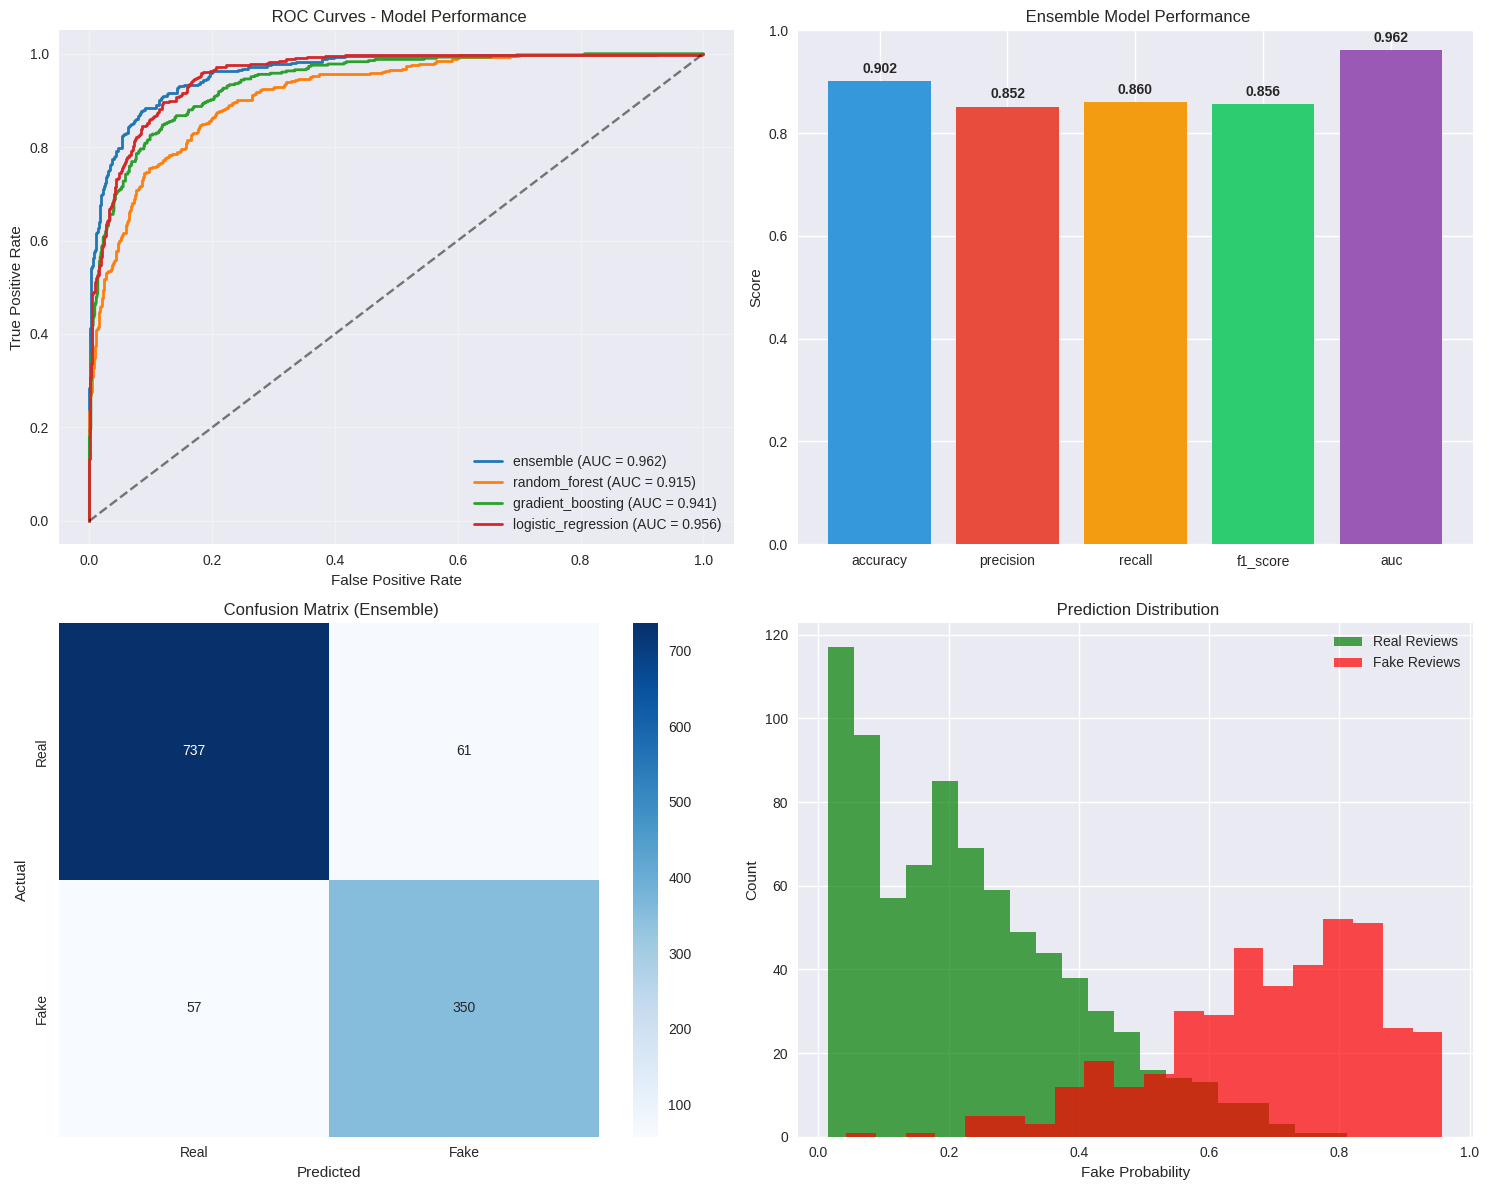

 Model training completed in 14.42 seconds!

 COMPREHENSIVE MODEL TESTING
Running 10 Malaysian-specific test cases...

 Test 1: Genuine Malaysian review test
   Text: Barang sampai cepat, quality ok, harga berbaloi. Seller responsive. Recommended!
    Prediction: REAL
    Confidence: 0.948
   Risk Level: MINIMAL
    Fake Probability: 0.052
   🇲🇾 Malaysian Terms: 3
    Mixed Language: False
    Prediction Time: 0.082s
    PASSED: Correctly identified as REAL

 Test 2: Excessive enthusiasm test
   Text: Best product ever!!!! Amazing quality!!!! 5 stars!!!! Buy now!!!!
    Prediction: REAL
    Confidence: 0.769
   Risk Level: MINIMAL
    Fake Probability: 0.231
   🇲🇾 Malaysian Terms: 1
    Mixed Language: False
    Prediction Time: 0.067s
    FAILED: Expected FAKE, got REAL

 Test 3: Mixed language genuine review
   Text: Product ok je, delivery lambat sikit but overall satisfied. Packaging neat.
    Prediction: REAL
    Confidence: 0.952
   Risk Level: MINIMAL
    Fake Probability: 0.048

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Files downloaded successfully!


 MODEL TRAINING COMPLETE!


 Your Model Performance:
   Accuracy: 90.2%
   Precision: 85.2%
   Recall: 86.0%
   F1-Score: 85.6%
   AUC: 96.2%
   Test Accuracy: 50.0%
   Prediction Speed: 0.111s

 Classification Results:
   Real Reviews: 3,988 (66.2%)
   Fake Reviews: 2,033 (33.8%)

 FRAUDITOR MODEL READY!
Now with proper Malaysian e-commerce review classification! 🇲🇾


In [11]:
if df is not None and len(df) > 100:
    print(" Training Frauditor Model!")
    print("="*60)

    # Initialize model
    model = FrauditorMLModel()

    # Train the model
    X_test, y_test = model.train_model(df)

    # Run comprehensive tests
    test_accuracy, test_results = run_tests(model)

    # Save the model
    model.save_model('frauditor_model.pkl')

    # Save test results
    test_results_df = pd.DataFrame(test_results)
    test_results_df.to_csv('test_results.csv', index=False)

    # Download files
    print("\n" + "="*60)
    print(" DOWNLOADING YOUR MODEL")
    print("="*60)

    try:
        files.download('frauditor_model.pkl')
        files.download('model_performance_report.json')
        files.download('merged_reviews_labeled.csv')
        files.download('test_results.csv')
        print(" Files downloaded successfully!")
    except:
        print(" Download manually if needed")

    # Final success message
    print("\n" + "" * 60)
    print(" MODEL TRAINING COMPLETE!")
    print("" * 60)

    print("\n Your Model Performance:")
    if 'ensemble' in model.performance_metrics:
        metrics = model.performance_metrics['ensemble']
        print(f"   Accuracy: {metrics['accuracy']:.1%}")
        print(f"   Precision: {metrics['precision']:.1%}")
        print(f"   Recall: {metrics['recall']:.1%}")
        print(f"   F1-Score: {metrics['f1_score']:.1%}")
        print(f"   AUC: {metrics['auc']:.1%}")
        print(f"   Test Accuracy: {test_accuracy:.1%}")
        print(f"   Prediction Speed: {metrics['prediction_time']:.3f}s")

    print("\n Classification Results:")
    real_count = (df['label'] == 0).sum()
    fake_count = (df['label'] == 1).sum()
    print(f"   Real Reviews: {real_count:,} ({real_count/len(df)*100:.1f}%)")
    print(f"   Fake Reviews: {fake_count:,} ({fake_count/len(df)*100:.1f}%)")

else:
    print("Insufficient data for training. Please upload your CSV files first!")

print("\n FRAUDITOR MODEL READY!")
print("Now with proper Malaysian e-commerce review classification! 🇲🇾")